In [2]:
%matplotlib inline

In [3]:
import pickle
import librosa
import librosa.display
import pretty_midi
from midi2audio import FluidSynth
import scipy
from scipy.io import wavfile
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from time import sleep

In [4]:
def showImage(X):
    plt.imshow(X, cmap='gray', norm = matplotlib.colors.Normalize())

In [5]:
def midiToWav(midiFile, outFile, samplingRate):
    fs = FluidSynth(sample_rate=samplingRate)
    fs.midi_to_audio(midiFile, outFile)

In [6]:
# file names
midiFile = 'Data/Beethoven_sonata27_Op90_Clean_Movement1.mid'
synthesizedWavFile = 'Output/synthesized.wav'
performanceWavFile = 'Data/Ashkenazy_plays_Beethoven_Sonata_No.27_in_E_minor_Op.90_Movement1.wav'

In [7]:
### read in the real performance, then use its sampling frequency when synthesizing the midi into audio (a wav)

# read in the real performance
performanceSamplingFreq, performanceAudio = wavfile.read(performanceWavFile)

# convert midi to wav file. It will output into synthesizedWavFile
midiToWav(midiFile, synthesizedWavFile, performanceSamplingFreq)

/Users/cstrong/anaconda/lib/python3.5/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [8]:
### generate chroma features for the real and synthesized wav files

# read in the synthesized file
synthesizedSamplingFreq, synthesizedAudio = wavfile.read(synthesizedWavFile)

# if the sampling freq are different I think this messes with things
if synthesizedSamplingFreq != performanceSamplingFreq:    
    print("WARNING: SAMPLING FREQUENCIES ARE NOT EQUAL")
# convert the audio data from stereo to mono if its in mono.
# we tell if its stereo by first checking it has more than one dimension,
# then checking that its second dimension is 2 (two columns, one for each part of the stereo signal)
if (len(synthesizedAudio.shape) != 1):
    if (synthesizedAudio.shape[1] == 2):
        synthesizedAudio = 0.5 * (synthesizedAudio[:, 0] + synthesizedAudio[:, 1])
if (len(performanceAudio) != 1):
    if (performanceAudio.shape[1] == 2):
        performanceAudio = 0.5 * (performanceAudio[:, 0] + performanceAudio[:, 1])

# generate the chroma features from the audio data and sampling rate
hopLength = 4096 # 4096 * (1/44100 s/sample) = 9.3ms
nFFT = 32768 # 32768 * (1/44100 s/sample) = 74 ms
synthesizedChromaFeatures = librosa.feature.chroma_stft(y = synthesizedAudio, sr = synthesizedSamplingFreq, hop_length = hopLength)
performanceChromaFeatures = librosa.feature.chroma_stft(y = performanceAudio, sr = performanceSamplingFreq, hop_length = hopLength)


In [9]:
### normalize the chroma features by their L2 norm in each column
synthesizedChromaFeatures = librosa.util.normalize(synthesizedChromaFeatures.astype(float), norm=2, axis=0)
performanceChromaFeatures = librosa.util.normalize(performanceChromaFeatures.astype(float), norm=2, axis=0)

# replace add a little to every location to avoid infinite costs
synthesizedChromaFeatures[synthesizedChromaFeatures == 0] = 0.00000000001
performanceChromaFeatures[performanceChromaFeatures == 0] = 0.00000000001

# less for now to speed computation
#synthesizedChromaFeatures = synthesizedChromaFeatures[:, 0:300]
#performanceChromaFeatures = performanceChromaFeatures[:, 0:300]

In [10]:
### TODO: turn into function, perform DTW on the matrices of chroma features. We'll use cosine distance as our metric
# returns the warping path in seconds

stepSizes = np.array([[0,1], [1, 0], [1, 1]])
weights = np.array([1, 1, 1])
accumCost, warpingPath = librosa.sequence.dtw(synthesizedChromaFeatures, performanceChromaFeatures, metric='cosine', step_sizes_sigma = stepSizes, weights_mul = weights)

In [11]:
### Get the ground truth

# use pretty_midi to find the times for each midi downbeat
midiData = pretty_midi.PrettyMIDI("Data/Beethoven_sonata27_Op90_Clean_Movement1.mid")
midiDownbeats = midiData.get_downbeats()[1:] # the first one it pulls out is at 0, we throw that away because there is no downbeat at 0
# load in our performance annotations
audioAnnotations = np.loadtxt(open("GroundTruth/beethoven_no27_op90_downbeat_annotations.csv"), delimiter=",")
audioAnnotations = audioAnnotations[:, 0] # throw out the annotation measure numbers (1.1, 1.2, etc)


In [12]:
### Find the % of ground truth points within a given threshold in the Y direction from the predicted path
### this involves interpolating between our predicted points for our path
def errorRate(predictedXs, predictedYs, groundTruthXs, groundTruthYs, threshold):
    interpolatedPredictedYs = np.interp(groundTruthXs, predictedXs, predictedYs)
    distances = interpolatedPredictedYs - groundTruthYs
    #plt.subplot(2,1,1)
    #plt.plot(range(0, len(distances)),distances)
    return 1 - sum(distances < threshold) / len(distances)

In [13]:
### visualize the mapping
def visualizeDTWResults(accumCost, predictedXs, predictedYs, groundTruthXs, groundTruthYs, samplingRate, hopLength):
    # a plot of the warping path on top of a color map of the accumulated cost matrix
    plt.subplot(2, 1, 1)
    #librosa.display.specshow(accumCost, x_axis='time', y_axis='time', sr = samplingRate, hop_length = hopLength)
    plt.title('MIDI, Performance DTW')
    plt.plot(predictedXs, predictedYs, label = 'Optimal Path', color='y')
    plt.plot(groundTruthXs, groundTruthYs, label = 'Ground Truth', color='w')
    plt.legend()

    # a plot of the cost function at each point on the path (how well each part of the alignment matches)
    plt.subplot(2, 1, 2)
    plt.plot(accumCost[-1, :] / predictedXs.shape[0])
    plt.xlim([0, accumCost.shape[1]])
    plt.ylim([0, 2])
    plt.title('Matching cost function')
    plt.tight_layout()


In [14]:
### visualize the error rate for the given mapping
def visualizeErrorRate(predictedXs, predictedYs, groundTruthXs, groundTruthYs):
    thresholds = np.linspace(0, 3, 100)
    errorRates = [errorRate(predictedXs, predictedYs, groundTruthXs, groundTruthYs, threshold) for threshold in thresholds]
    plt.plot(thresholds, errorRates)
    plt.title("Error Rate vs. Threshold")
    plt.xlabel('Threshold (seconds)')
    plt.ylabel('Error Rate')


In [15]:
### Convert the warping path to time in seconds
timePerFrame = hopLength / float(synthesizedSamplingFreq) # in seconds
warpingPathInSeconds = warpingPath * timePerFrame
synthesizedTimes = np.flip(warpingPathInSeconds[:, 0]) # flip because they come out in descending order and we want ascending order
performanceTimes = np.flip(warpingPathInSeconds[:, 1]) # flip because they come out in descending order and we want ascending order

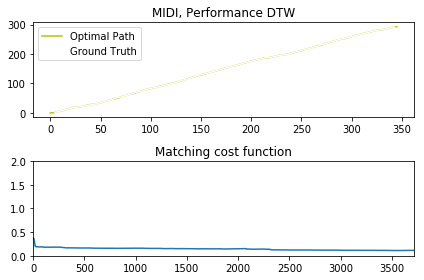

In [16]:
### visualize the warping path alongside the ground truth, as well as the cost function along the path
visualizeDTWResults(accumCost, performanceTimes, synthesizedTimes, audioAnnotations, midiDownbeats, synthesizedSamplingFreq, hopLength)

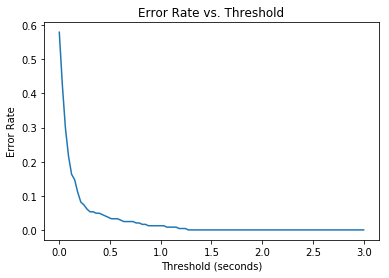

In [17]:
### see how well we match the ground truth
visualizeErrorRate(performanceTimes, synthesizedTimes, audioAnnotations, midiDownbeats)

In [18]:
### output the warping path in seconds to a csv
np.savetxt('Output/warpingPath.csv', warpingPathInSeconds, delimiter=',')

In [19]:
### output the midi times associated with each annotated downbeat
midiPredictionsForAudioAnnotations = np.interp(audioAnnotations, performanceTimes, synthesizedTimes)
np.savetxt('Output/midiTimeForAudioDownbeats.csv', midiPredictionsForAudioAnnotations, delimiter=',')

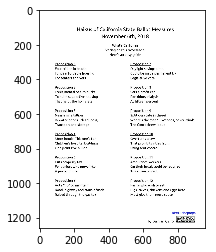

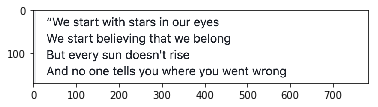

In [26]:
### image testing
img=mpimg.imread('testpng.png')

imgplot = plt.imshow(img)
plt.show()
sleep(0.5)
plt.close()
img = mpimg.imread('test2.png')
imgplot = plt.imshow(img)
plt.show()
